In [1]:
from typing import TypedDict, Annotated, List, Dict
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langchain_openai.chat_models.base import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage

from dotenv import load_dotenv
from langsmith import Client
import json

import sqlite3
from langchain_community.utilities.sql_database import SQLDatabase
from sqlalchemy import create_engine
from sqlalchemy.pool import StaticPool

load_dotenv() 
client = Client() # langsmith 추적

class RealEstateState(TypedDict): # 그래프의 상태를 정의하는 클래스
    real_estate_type: Annotated[str ,"부동산 유형 (예: 아파트, 상가)"]
    keywordlist: Annotated[List[Dict] ,"키워드 리스트"]
    messages: Annotated[list, add_messages]
    query_sql: Annotated[str ,"생성된 SQL 쿼리"]
    results: Annotated[List[Dict], "쿼리 결과"]
    answers: Annotated[List[str], "최종 답변 결과"]
    query_answer:Annotated[str, 'answer다듬기']

# Step 1: LLM 초기화
llm = ChatOpenAI(model="gpt-4o-mini", temperature=1)

# Step 2: StateGraph 정의
workflow = StateGraph(RealEstateState)

In [2]:
def filter_node(state:RealEstateState) -> RealEstateState:
    system_prompt = """
    Classify if a given question is related to real estate. If the question is related to topics such as property transactions, rental conditions, location recommendations, or property features, return Pass. If it's not directly related to real estate, return Fail.

    # Output Format
    - Return Pass if the question is real estate-related, otherwise return Fail.

    # Examples
    - 입력: '서울 아파트 매매 가격이 어떻게 되나요?'
      출력: Pass

    - 입력: '이 동네 전세 시세 알려주세요'
      출력: Pass

    - 입력: '서울에서 월세 계약 조건이 어떻게 되나요?'
      출력: Pass

    - 입력: '서울 아파트 매매가 얼마인가요?'
      출력: Pass

    - 입력: '대치동에서 버스정류장과 지하철이 가장 가까운 곳으로 알려줘'
      출력: Pass

    - 입력: '여자 혼자 살기 좋은 곳 추천해줘'
      출력: Pass

    - 입력: '교통이 편리하고 저렴한 원룸 추천해줘'
      출력: Pass

    - 입력: '이 음식점이 맛있나요?'
      출력: Fail

    - 입력: '서울에서 가장 큰 공원이 어디인가요?'
      출력: Fail
    """
    response = llm.invoke([
        SystemMessage(content=system_prompt),
        HumanMessage(state["messages"][-1].content)
    ])

    real_estate_type = response.content.strip()
    return RealEstateState(real_estate_type=real_estate_type)

def fiter_router(state: RealEstateState):
    # This is the router
    real_estate_type = state["real_estate_type"]
    if real_estate_type == "Pass":
        return "Pass"
    else:
        return 'Fail'
    
def re_questions(state: RealEstateState) -> RealEstateState:
    print("=================================")
    print("""[re_questions] 질문이 부동산 관련이 아니거나 제대로 인식되지 않았습니다.
          부동산 관련 질문을 좀 더 자세하게 작성해주시면 답변드리겠습니다!!!""")
    new_question = input("새로운 부동산 질문을 입력해주세요: ")
    print("=================================")
    # 수정된 질문을 state에 업데이트
    return RealEstateState(messages=new_question)

In [3]:
import sqlite3
from langchain_community.utilities.sql_database import SQLDatabase
from sqlalchemy import create_engine
from sqlalchemy.pool import StaticPool

def get_db_engine(db_path):
    """로컬 SQLite DB 파일과 연결된 엔진을 생성합니다."""
    try:
        # SQLite DB 파일과 연결
        connection = sqlite3.connect(db_path, check_same_thread=False)
        # SQLAlchemy 엔진 생성
        engine = create_engine(
            f"sqlite:///{db_path}",
            poolclass=StaticPool,
            connect_args={"check_same_thread": False}
        )
        return engine
    except Exception as e:
        print(f"데이터베이스 연결 중 오류 발생: {str(e)}")
        return None
    
    
# DB 파일 경로 지정
db_path = './data/real_estate_(1).db'
engine = get_db_engine(db_path)
db = SQLDatabase(
    engine,
    sample_rows_in_table_info=False  # 샘플 행 조회 비활성화
)

In [4]:
def generate_query(state: RealEstateState) -> RealEstateState:
    table = db.get_table_info(table_names=["addresses","sales", "rentals", "property_info", "property_locations","location_distances", "subway_stations"])
    prompt = f"""
    다음 데이터베이스 구조를 기반으로 사용자의 질문에 대한 SQL 쿼리를 생성해주세요:
    
    테이블 및 주요 컬럼 설명:
    {table}

    거리 및 대중교통 관련 계산 규칙:
    - **대중교통과 매물간의 거리 계산**: 테이블들을 활용해서 계산합니다.

    주의사항:
    1. 관련 조건은 SQL WHERE 절 형식으로 작성해주세요.
    2. '최근 5년' 같은 상대적 시간 표현은 현재 날짜 기준으로 변환해주세요.
    3. '추천할 만한', '인기 있는' 등의 표현은 적절히 해석하여 조건을 추가해주세요. 예: 'crime_rate < 5' 또는 'population_level = "높음"'.
    4. 텍스트 검색에는 LIKE 또는 MATCH ... AGAINST를 활용하세요.
    5. 여러 조건은 AND 또는 OR로 연결하세요.
    6. 정렬, 그룹화 등이 필요한 경우 이를 추가로 명시하세요. 예: ORDER BY created_at DESC.
    7. 쿼리만 작성하고 추가 설명은 하지 마세요.
    8. rental_type 값은 다음과 같습니다:
        - 'MONTHLY': 전세
        - 'YEARLY': 월세
    9. facilities는 영어로 쳐야지 나옵니다.
        - pi.facilities LIKE '%ELEVATOR%' -> 엘리베이터
        - pi.facilities LIKE '%aircon%' -> 에이컨, 에어콘
    10. 매물번호도 함께 보여주세요 매물번호는 property_id입니다.
    11. rentals 테이블에 price라는 컬럼이 없습니다. rentals 테이블에는 price 대신 deposit(보증금)과 monthly_rent(월세) 컬럼이 존재합니다.

    사용자 질문: {state['messages'][-1].content}

    SQL 쿼리 형식:
    SELECT * FROM table_name WHERE condition1 AND condition2 ...;
    """

    response = llm.invoke([
            SystemMessage(content="당신은 SQLite Database  쿼리를 생성하는 전문가입니다."),
            HumanMessage(prompt)
        ])
    
    return RealEstateState(query_sql=response.content)

In [5]:
def clean_sql_response(state: RealEstateState) -> RealEstateState:
    # 'query_sql' 키는 항상 존재한다고 가정
    query_sql = state['query_sql']

    # 코드 블록(````sql ... `````) 제거
    if query_sql.startswith("```sql") and query_sql.endswith("```"):
        query_sql = query_sql[6:-3].strip()  # "```sql" 제거 후 앞뒤 공백 제거

    # SQL 문 끝에 세미콜론 추가 (필요시)
    if not query_sql.strip().endswith(";"):
        query_sql = query_sql.strip() + ";"
        

    # 상태 업데이트
    return RealEstateState(query_sql=query_sql)

In [6]:
from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool

def run_query(state: RealEstateState) -> RealEstateState:
    
    tool = QuerySQLDataBaseTool(db=db)
    results = tool._run(state["query_sql"])

    if results == '':
        results = '결과값이 없습니다!!! 다시 질문해주세요!'
        return RealEstateState(results=results)

    return RealEstateState(results=results)

In [7]:
def generate_response(state: RealEstateState)-> RealEstateState:
    prompt = state['messages'][-1].content
    context = state['results']
    context += "위 매물들에 대한 추천과 함께, 각 부동산과 관련된 세계 지식과 흥미로운 사실을 추가해주세요."

    response = llm.invoke([
            SystemMessage(content="당신은 부동산산 추천 전문가이자 세계 지식을 갖춘 AI입니다. 주어진 정보와 세계 지식을 결합하여 사용자의 질문에 답변해주세요. 구분선 이후 간단한 추천이유도 적어줍니다."),
            HumanMessage(content= f"컨텍스트: {context}\n\n질문: {prompt}\n\n각 부동산에 대해 관련된 세계 지식과 흥미로운 사실을 추가해주세요.")
        ])
    
    output = response.content.strip()

    return RealEstateState(answers=output)

In [8]:
workflow.add_node("Filter Question", filter_node)
workflow.add_node('Re_Questions', re_questions)
workflow.add_node('Generate_Query', generate_query)
workflow.add_node('Clean_Sql_Response', clean_sql_response)
workflow.add_node('Run_Query', run_query)
workflow.add_node('Generate_Response', generate_response)

In [9]:
workflow.add_conditional_edges(
    "Filter Question",
    fiter_router,
    { 'Pass': "Generate_Query", 'Fail': 'Re_Questions'}
)

In [10]:
workflow.add_edge(START, "Filter Question")
workflow.add_edge("Re_Questions", "Filter Question")
workflow.add_edge("Generate_Query", "Clean_Sql_Response")
workflow.add_edge("Clean_Sql_Response", "Run_Query")
workflow.add_edge("Run_Query", "Generate_Response")
workflow.add_edge("Generate_Response", END)

In [11]:
app = workflow.compile()

In [16]:
result = app.invoke({'messages': '금천구 보증금 1000만원에 월세 50짜리 찾아줘!!!'})

In [17]:
print(result['answers'])

현재 금천구에서 보증금 1,000만원에 월세 50만원인 부동산 매물을 직접적으로 제공할 수는 없습니다. 그러나 적합한 부동산을 찾기 위한 팁과 이와 관련된 세계적인 데이터를 제공하겠습니다.

### 추천 팁:
1. **부동산 웹사이트 이용**: 한국의 주요 부동산 플랫폼(예: 직방, 다방 등)을 활용하여 검색 필터를 설정하시면 쉽게 매물을 찾을 수 있습니다.
2. **지역 정보 파악**: 금천구의 특징과 장단점을 파악하고, 원하는 생활 환경을 기준으로 매물을 검토하세요.
3. **부동산 중개인 상담**: 지역의 부동산 중개인을 방문하여 더욱 구체적인 정보와 현장 매물을 추천받는 것이 유리합니다.

### 세계적인 지식 및 흥미로운 사실:
- **거주비 비교**: 금천구와 같은 서울의 일부 지역은 다른 대도시(예: 뉴욕, 런던)의 평균 임대료와 비교해 상대적으로 저렴할 수 있습니다. 이는 서울의 부동산 시장이 지역별로 큰 차이를 보이기 때문입니다.
  
- **아파트 트렌드**: 한국은 아파트에서의 생활이 일반적인데, 이는 주거 공간을 효과적으로 관리하려는 문화에서 기인합니다. 비슷한 트렌드는 일본에서도 발견되며, 고밀도 도시에서의 주거 공간 효율성이 강조됩니다.

이 정보들이 원하는 매물을 찾는 데 도움이 되기를 바랍니다!


In [18]:
print(result)

{'real_estate_type': 'Pass', 'messages': [HumanMessage(content='금천구 보증금 1000만원에\xa0월세 50짜리 찾아줘!!!', additional_kwargs={}, response_metadata={}, id='d3aca2ac-2b49-4edc-8ee0-7811c7b41c8b')], 'query_sql': "SELECT pi.property_id, r.deposit, r.monthly_rent \nFROM property_info pi\nJOIN rentals r ON pi.property_id = r.property_id\nJOIN property_locations pl ON pi.property_location_id = pl.property_location_id\nWHERE pl.sigungu = '금천구' \nAND r.deposit <= 10000000 \nAND r.monthly_rent <= 50000;", 'results': '결과값이 없습니다!!! 다시 질문해주세요!', 'answers': '현재 금천구에서 보증금 1,000만원에 월세 50만원인 부동산 매물을 직접적으로 제공할 수는 없습니다. 그러나 적합한 부동산을 찾기 위한 팁과 이와 관련된 세계적인 데이터를 제공하겠습니다.\n\n### 추천 팁:\n1. **부동산 웹사이트 이용**: 한국의 주요 부동산 플랫폼(예: 직방, 다방 등)을 활용하여 검색 필터를 설정하시면 쉽게 매물을 찾을 수 있습니다.\n2. **지역 정보 파악**: 금천구의 특징과 장단점을 파악하고, 원하는 생활 환경을 기준으로 매물을 검토하세요.\n3. **부동산 중개인 상담**: 지역의 부동산 중개인을 방문하여 더욱 구체적인 정보와 현장 매물을 추천받는 것이 유리합니다.\n\n### 세계적인 지식 및 흥미로운 사실:\n- **거주비 비교**: 금천구와 같은 서울의 일부 지역은 다른 대도시(예: 뉴욕, 런던)의 평균 임대료와 비교해 상대적으로 저렴할 수 있습니다. 이는 서울

In [20]:
result['keywordlist']

KeyError: 'keywordlist'

In [19]:
print(result['query_sql'])

SELECT pi.property_id, r.deposit, r.monthly_rent 
FROM property_info pi
JOIN rentals r ON pi.property_id = r.property_id
JOIN property_locations pl ON pi.property_location_id = pl.property_location_id
WHERE pl.sigungu = '금천구' 
AND r.deposit <= 10000000 
AND r.monthly_rent <= 50000;


In [17]:
from typing import TypedDict, Annotated, List, Dict
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langchain_openai.chat_models.base import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage

from dotenv import load_dotenv
from langsmith import Client
import json

import sqlite3
from langchain_community.utilities.sql_database import SQLDatabase
from sqlalchemy import create_engine
from sqlalchemy.pool import StaticPool

load_dotenv() 
client = Client() # langsmith 추적

class RealEstateState(TypedDict): # 그래프의 상태를 정의하는 클래스
    real_estate_type: Annotated[str ,"부동산 유형 (예: 아파트, 상가)"]
    keywordlist: Annotated[List[Dict] ,"키워드 리스트"]
    messages: Annotated[list, add_messages]
    query_sql: Annotated[str ,"생성된 SQL 쿼리"]
    results: Annotated[List[Dict], "쿼리 결과"]
    answers: Annotated[List[str], "최종 답변 결과"]
    query_answer:Annotated[str, 'answer다듬기']

# Step 1: LLM 초기화
llm = ChatOpenAI(model="gpt-4o-mini", temperature=1)

# Step 2: StateGraph 정의
workflow = StateGraph(RealEstateState)

def filter_node(state:RealEstateState) -> RealEstateState:
    system_prompt = """
    Classify if a given question is related to real estate. If the question is related to topics such as property transactions, rental conditions, location recommendations, or property features, return Pass. If it's not directly related to real estate, return Fail.

    # Output Format
    - Return Pass if the question is real estate-related, otherwise return Fail.

    # Examples
    - 입력: '서울 아파트 매매 가격이 어떻게 되나요?'
      출력: Pass

    - 입력: '이 동네 전세 시세 알려주세요'
      출력: Pass

    - 입력: '서울에서 월세 계약 조건이 어떻게 되나요?'
      출력: Pass

    - 입력: '서울 아파트 매매가 얼마인가요?'
      출력: Pass

    - 입력: '대치동에서 버스정류장과 지하철이 가장 가까운 곳으로 알려줘'
      출력: Pass

    - 입력: '여자 혼자 살기 좋은 곳 추천해줘'
      출력: Pass

    - 입력: '교통이 편리하고 저렴한 원룸 추천해줘'
      출력: Pass

    - 입력: '이 음식점이 맛있나요?'
      출력: Fail

    - 입력: '서울에서 가장 큰 공원이 어디인가요?'
      출력: Fail
    """
    response = llm.invoke([
        SystemMessage(content=system_prompt),
        HumanMessage(state["messages"][-1].content)
    ])

    real_estate_type = response.content.strip()
    return RealEstateState(real_estate_type=real_estate_type)

def fiter_router(state: RealEstateState):
    # This is the router
    real_estate_type = state["real_estate_type"]
    if real_estate_type == "Pass":
        return "Pass"
    else:
        return 'Fail'
    
def re_questions(state: RealEstateState) -> RealEstateState:
    print("=================================")
    print("""[re_questions] 질문이 부동산 관련이 아니거나 제대로 인식되지 않았습니다.
          부동산 관련 질문을 좀 더 자세하게 작성해주시면 답변드리겠습니다!!!""")
    new_question = input("새로운 부동산 질문을 입력해주세요: ")
    print("=================================")
    # 수정된 질문을 state에 업데이트
    return RealEstateState(messages=new_question)

import sqlite3
from langchain_community.utilities.sql_database import SQLDatabase
from sqlalchemy import create_engine
from sqlalchemy.pool import StaticPool

def get_db_engine(db_path):
    """로컬 SQLite DB 파일과 연결된 엔진을 생성합니다."""
    try:
        # SQLite DB 파일과 연결
        connection = sqlite3.connect(db_path, check_same_thread=False)
        # SQLAlchemy 엔진 생성
        engine = create_engine(
            f"sqlite:///{db_path}",
            poolclass=StaticPool,
            connect_args={"check_same_thread": False}
        )
        return engine
    except Exception as e:
        print(f"데이터베이스 연결 중 오류 발생: {str(e)}")
        return None
    
    
# DB 파일 경로 지정
db_path = './data/real_estate_(1).db'
engine = get_db_engine(db_path)
db = SQLDatabase(
    engine,
    sample_rows_in_table_info=False  # 샘플 행 조회 비활성화
)

def generate_query(state: RealEstateState) -> RealEstateState:
    table = db.get_table_info(table_names=["addresses","sales", "rentals", "property_info", "property_locations","location_distances"])
    prompt = f"""
    다음 데이터베이스 구조를 기반으로 사용자의 질문에 대한 SQL 쿼리를 생성해주세요:
    
    테이블 및 주요 컬럼 설명:
    {table}

    거리 및 대중교통 관련 계산 규칙:
    - **대중교통과 매물간의 거리 계산**: 테이블들을 활용해서 계산합니다.

    주의사항:
    1. 관련 조건은 SQL WHERE 절 형식으로 작성해주세요.
    2. '최근 5년' 같은 상대적 시간 표현은 현재 날짜 기준으로 변환해주세요.
    3. '추천할 만한', '인기 있는' 등의 표현은 적절히 해석하여 조건을 추가해주세요. 예: 'crime_rate < 5' 또는 'population_level = "높음"'.
    4. 텍스트 검색에는 LIKE 또는 MATCH ... AGAINST를 활용하세요.
    5. 여러 조건은 AND 또는 OR로 연결하세요.
    6. 정렬, 그룹화 등이 필요한 경우 이를 추가로 명시하세요. 예: ORDER BY created_at DESC.
    7. 쿼리만 작성하고 추가 설명은 하지 마세요.
    8. rental_type 값은 다음과 같습니다:
        - 'MONTHLY': 전세
        - 'YEARLY': 월세

    9. facilities는 영어로 쳐야지 나옵니다.
        - pi.facilities LIKE '%ELEVATOR%' -> 엘리베이터
        - pi.facilities LIKE '%aircon%' -> 에이컨, 에어콘

    10. 매물번호도 함께 보여주세요 매물번호는 property_id입니다.

    11. rentals 테이블에 price라는 컬럼이 없습니다. rentals 테이블에는 price 대신 deposit(보증금)과 monthly_rent(월세) 컬럼이 존재합니다.
    
    12. description은 매물에 대한 설명이 적혀있습니다. 쿼리를 짤 때 무조건 포함 시키세요.

    사용자 질문: {state['messages'][-1].content}

    SQL 쿼리 형식:
    SELECT * FROM table_name WHERE condition1 AND condition2 ...;
    """

    response = llm.invoke([
            SystemMessage(content="당신은 SQLite Database  쿼리를 생성하는 전문가입니다."),
            HumanMessage(prompt)
        ])
    
    return RealEstateState(query_sql=response.content)

def clean_sql_response(state: RealEstateState) -> RealEstateState:
    # 'query_sql' 키는 항상 존재한다고 가정
    query_sql = state['query_sql']

    # 코드 블록(````sql ... `````) 제거
    if query_sql.startswith("```sql") and query_sql.endswith("```"):
        query_sql = query_sql[6:-3].strip()  # "```sql" 제거 후 앞뒤 공백 제거

    # SQL 문 끝에 세미콜론 추가 (필요시)
    if not query_sql.strip().endswith(";"):
        query_sql = query_sql.strip() + ";"
        

    # 상태 업데이트
    return RealEstateState(query_sql=query_sql)

from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool

def run_query(state: RealEstateState) -> RealEstateState:
    
    tool = QuerySQLDataBaseTool(db=db)
    results = tool._run(state["query_sql"])

    if results == '':
        results = '결과값이 없습니다!!! 다시 질문해주세요!'
        return RealEstateState(results=results)

    return RealEstateState(results=results)

def generate_response(state: RealEstateState)-> RealEstateState:
    prompt = state['messages'][-1].content
    context = state['results']
    context += "위 매물들에 대한 추천과 함께, 각 부동산과 관련된 세계 지식과 흥미로운 사실을 추가해주세요."

    response = llm.invoke([
            SystemMessage(content="당신은 부동산 추천 전문가이자 세계 지식을 갖춘 AI입니다. 주어진 정보와 세계 지식을 결합하여 사용자의 질문에 답변해주세요. 답변 맨위에는 매물번호를 적어주세요. 구분선 이후 간단한 추천이유도 적어줍니다."),
            HumanMessage(content= f"컨텍스트: {context}\n\n질문: {prompt}\n\n각 부동산에 대해 관련된 세계 지식과 흥미로운 사실을 추가해주세요.")
        ])
    
    output = response.content.strip()

    return RealEstateState(answers=output)

workflow.add_node("Filter Question", filter_node)
workflow.add_node('Re_Questions', re_questions)
workflow.add_node('Generate_Query', generate_query)
workflow.add_node('Clean_Sql_Response', clean_sql_response)
workflow.add_node('Run_Query', run_query)
workflow.add_node('Generate_Response', generate_response)

workflow.add_conditional_edges(
    "Filter Question",
    fiter_router,
    { 'Pass': "Generate_Query", 'Fail': 'Re_Questions'}
)

workflow.add_edge(START, "Filter Question")
workflow.add_edge("Re_Questions", "Filter Question")
workflow.add_edge("Generate_Query", "Clean_Sql_Response")
workflow.add_edge("Clean_Sql_Response", "Run_Query")
workflow.add_edge("Run_Query", "Generate_Response")
workflow.add_edge("Generate_Response", END)

app = workflow.compile()

result = app.invoke({'messages': '서울시 강남역에서 1000미터 이내 전세 10억 매물을 추천해줘'})

In [18]:
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"},  # 스레드 ID 설정
    tags=["my-rag"],  # Tag
)
memory = MemorySaver()

In [19]:
from typing import TypedDict, Annotated, List, Dict
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langchain_openai.chat_models.base import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from dotenv import load_dotenv
from langsmith import Client
import json
import sqlite3
from langchain_community.utilities.sql_database import SQLDatabase
from sqlalchemy import create_engine
from sqlalchemy.pool import StaticPool

load_dotenv() 
client = Client()  # LangSmith tracking

class RealEstateState(TypedDict):
    real_estate_type: Annotated[str, "부동산 유형 (예: 아파트, 상가)"]
    keywordlist: Annotated[List[Dict], "키워드 리스트"]
    messages: Annotated[list, add_messages]
    query_sql: Annotated[str, "생성된 SQL 쿼리"]
    results: Annotated[List[Dict], "쿼리 결과"]
    answers: Annotated[List[str], "최종 답변 결과"]
    query_answer: Annotated[str, 'answer다듬기']

# Step 1: LLM 초기화
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.5)

# Step 2: StateGraph 정의
workflow = StateGraph(RealEstateState)

# Stream utility
import sys

def stream_output(message):
    sys.stdout.write(message + "\n")
    sys.stdout.flush()

def filter_node(state: RealEstateState) -> RealEstateState:
    stream_output("[Filter Node] AI가 질문을 식별중입니다!!!!")
    system_prompt = """
    Classify if a given question is related to real estate. If the question is related to topics such as property transactions, rental conditions, location recommendations, or property features, return Pass. If it's not directly related to real estate, return Fail.

    # Output Format
    - Return Pass if the question is real estate-related, otherwise return Fail.

    # Examples
    - 입력: '서울 아파트 매매 가격이 어떻게 되나요?'
      출력: Pass

    - 입력: '이 동네 전세 시세 알려주세요'
      출력: Pass

    - 입력: '서울에서 월세 계약 조건이 어떻게 되나요?'
      출력: Pass

    - 입력: '서울 아파트 매매가 얼마인가요?'
      출력: Pass

    - 입력: '대치동에서 버스정류장과 지하철이 가장 가까운 곳으로 알려줘'
      출력: Pass

    - 입력: '여자 혼자 살기 좋은 곳 추천해줘'
      출력: Pass

    - 입력: '교통이 편리하고 저렴한 원룸 추천해줘'
      출력: Pass

    - 입력: '이 음식점이 맛있나요?'
      출력: Fail

    - 입력: '서울에서 가장 큰 공원이 어디인가요?'
      출력: Fail
    """
    response = llm.invoke([
        SystemMessage(content=system_prompt),
        HumanMessage(state["messages"][-1].content)
    ])

    real_estate_type = response.content.strip()
    stream_output(f"[Filter Node] AI가 질문을 식별했습니다.: {real_estate_type}")
    return RealEstateState(real_estate_type=real_estate_type)

def fiter_router(state: RealEstateState):
    # This is the router
    real_estate_type = state["real_estate_type"]
    if real_estate_type == "Pass":
        return "Pass"
    else:
        return 'Fail'

def re_questions(state: RealEstateState) -> RealEstateState:
    stream_output("=================================")
    stream_output("""[re_questions] 질문이 부동산 관련이 아니거나 제대로 인식되지 않았습니다.
          부동산 관련 질문을 좀 더 자세하게 작성해주시면 답변드리겠습니다!!!""")
    new_question = input("새로운 부동산 질문을 입력해주세요: ")
    stream_output("=================================")
    return RealEstateState(messages=new_question)

def get_db_engine(db_path):
    """로컬 SQLite DB 파일과 연결된 엔진을 생성합니다."""
    try:
        # SQLite DB 파일과 연결
        connection = sqlite3.connect(db_path, check_same_thread=False)
        # SQLAlchemy 엔진 생성
        engine = create_engine(
            f"sqlite:///{db_path}",
            poolclass=StaticPool,
            connect_args={"check_same_thread": False}
        )
        return engine
    except Exception as e:
        print(f"데이터베이스 연결 중 오류 발생: {str(e)}")
        return None
    
    
# DB 파일 경로 지정
db_path = './data/real_estate_(1).db'
engine = get_db_engine(db_path)
db = SQLDatabase(
    engine,
    sample_rows_in_table_info=False  # 샘플 행 조회 비활성화
)

def generate_query(state: RealEstateState) -> RealEstateState:
    stream_output("[Generate Query] AI가 쿼리를 생성중입니다...")
    
    table = db.get_table_info(table_names=["addresses", "sales", "rentals", "property_info", "property_locations", "location_distances", "subway_stations"])
    prompt = f"""
    다음 데이터베이스 구조를 기반으로 사용자의 질문에 대한 SQL 쿼리를 생성해주세요:
    
    테이블 및 주요 컬럼 설명:
    {table}

    거리 및 대중교통 관련 계산 규칙:
    - **대중교통과 매물간의 거리 계산**: 테이블들을 활용해서 계산합니다.

    주의사항:
    1. 관련 조건은 SQL WHERE 절 형식으로 작성해주세요.
    2. '최근 5년' 같은 상대적 시간 표현은 현재 날짜 기준으로 변환해주세요.
    3. '추천할 만한', '인기 있는' 등의 표현은 적절히 해석하여 조건을 추가해주세요. 예: 'crime_rate < 5' 또는 'population_level = "높음"'.
    4. 텍스트 검색에는 LIKE 또는 MATCH ... AGAINST를 활용하세요.
    5. 여러 조건은 AND 또는 OR로 연결하세요.
    6. 정렬, 그룹화 등이 필요한 경우 이를 추가로 명시하세요. 예: ORDER BY created_at DESC.
    7. 쿼리만 작성하고 추가 설명은 하지 마세요.
    8. rental_type 값은 다음과 같습니다:
        - 'MONTHLY': 전세
        - 'YEARLY': 월세
    9. facilities는 영어로 쳐야지 나옵니다.
        - pi.facilities LIKE '%ELEVATOR%' -> 엘리베이터
        - pi.facilities LIKE '%aircon%' -> 에이컨, 에어콘
    10. property_info 테이블 안에 있는 칼럼인 property_id를 반드시 포함해주세요.
    11. rentals 테이블에 price라는 컬럼이 없습니다. rentals 테이블에는 price 대신 deposit(보증금)과 monthly_rent(월세) 컬럼이 존재합니다.
    12. property_info 테이블 안에 있는 칼럼인 description에는 매물에 대한 설명이 적혀있습니다. 반드시 포함해주세요.
    13. pl.sido에는 값이 '서울특별시'밖에 없습니다. 해당 칼럼은 사용하지마세요.
    
    14. 돈과 관련된 칼럼인 price, deposit과 monthly_rent는 반드시 보여주세요.

    15. 쿼리문은 결과값이 5개만 나오게 해줘
    
    사용자 질문: {state['messages'][-1].content}

    SQL 쿼리 형식:
    SELECT * FROM table_name WHERE condition1 AND condition2 ...;
    """

    response = llm.invoke([
        SystemMessage(content="당신은 SQLite Database 쿼리를 생성하는 전문가입니다."),
        HumanMessage(prompt)
    ])

    stream_output("[Generate Query] AI가 데이터베이스 쿼리를 생성했습니다.")
    return RealEstateState(query_sql=response.content)

def clean_sql_response(state: RealEstateState) -> RealEstateState:
    stream_output("[Clean SQL Response] 쿼리를 이쁘게 만들고 있습니다...")
    query_sql = state['query_sql']

    if query_sql.startswith("```sql") and query_sql.endswith("```"):
        query_sql = query_sql[6:-3].strip()

    if not query_sql.strip().endswith(";"):
        query_sql = query_sql.strip() + ";"

    stream_output("[Clean SQL Response] 쿼리 정제가 끝났습니다.")
    return RealEstateState(query_sql=query_sql)

def run_query(state: RealEstateState) -> RealEstateState:
    stream_output("[Run Query] 쿼리 실행중...")
    tool = QuerySQLDataBaseTool(db=db)
    results = tool._run(state["query_sql"])

    if results == '':
        results = '쿼리 실행 결과값이 없습니다!'
        stream_output("[Run Query] 쿼리 실행 결과값이 없습니다!")
        return RealEstateState(results=results)

    stream_output("[Run Query] 쿼리 실행 성공.")
    return RealEstateState(results=results)

def generate_response(state: RealEstateState) -> RealEstateState:
    stream_output("[Generate Response] 거의 다 했어요...")
    prompt = state['messages'][-1].content
    context = state['results']
    # context += """
    #         위 매물들에 대한 추천과 함께 부동산 답변과 관련된 세계 지식과 흥미로운 사실을 추가해주세요.
    #         """

    response = llm.invoke([
        SystemMessage(content="""
                        당신은 부동산 추천 전문가입니다.
                        사용자 질문에 부동산 매물을 추천해주세요요
                        답변에는 오직 property_id와 간단한 추천이유만 적어줍니다.
                        """
                    ),
        HumanMessage(content= f"컨텍스트: {context}\n\n질문: {prompt}\n\n각 부동산에 대해 관련된 세계 지식과 흥미로운 사실을 추가해주세요.")
    ])

    output = response.content.strip()
    stream_output("[Generate Response] 답변 생성 끝.")
    return RealEstateState(answers=output)

workflow.add_node("Filter Question", filter_node)
workflow.add_node('Re_Questions', re_questions)
workflow.add_node('Generate_Query', generate_query)
workflow.add_node('Clean_Sql_Response', clean_sql_response)
workflow.add_node('Run_Query', run_query)
workflow.add_node('Generate_Response', generate_response)

workflow.add_conditional_edges(
    "Filter Question",
    fiter_router,
    { 'Pass': "Generate_Query", 'Fail': 'Re_Questions'}
)

workflow.add_edge(START, "Filter Question")
workflow.add_edge("Re_Questions", "Filter Question")
workflow.add_edge("Generate_Query", "Clean_Sql_Response")
workflow.add_edge("Clean_Sql_Response", "Run_Query")
workflow.add_edge("Run_Query", "Generate_Response")
workflow.add_edge("Generate_Response", END)

app = workflow.compile()
while True:
    user_input = input()
    if user_input == 'q':
        break
    result = app.invoke({'messages': user_input}, config=config)
    print(result['answers'])


[Filter Node] AI가 질문을 식별중입니다!!!!
[Filter Node] AI가 질문을 식별했습니다.: Pass
[Generate Query] AI가 쿼리를 생성중입니다...
[Generate Query] AI가 데이터베이스 쿼리를 생성했습니다.
[Clean SQL Response] 쿼리를 이쁘게 만들고 있습니다...
[Clean SQL Response] 쿼리 정제가 끝났습니다.
[Run Query] 쿼리 실행중...
[Run Query] 쿼리 실행 결과값이 없습니다!
[Generate Response] 거의 다 했어요...
[Generate Response] 답변 생성 끝.
죄송하지만, 요청하신 매물에 대한 정보가 없습니다.
[Filter Node] AI가 질문을 식별중입니다!!!!
[Filter Node] AI가 질문을 식별했습니다.: Pass
[Generate Query] AI가 쿼리를 생성중입니다...
[Generate Query] AI가 데이터베이스 쿼리를 생성했습니다.
[Clean SQL Response] 쿼리를 이쁘게 만들고 있습니다...
[Clean SQL Response] 쿼리 정제가 끝났습니다.
[Run Query] 쿼리 실행중...
[Run Query] 쿼리 실행 결과값이 없습니다!
[Generate Response] 거의 다 했어요...
[Generate Response] 답변 생성 끝.
죄송합니다. 해당 조건에 맞는 매물이 없습니다.


In [20]:
print(result['query_sql'])

SELECT pi.property_id, r.deposit, r.monthly_rent, pi.description 
FROM property_info pi
JOIN rentals r ON pi.property_id = r.property_id
JOIN property_locations pl ON pi.property_location_id = pl.property_location_id
JOIN subway_stations ss ON ss.address_id = pl.property_location_id
JOIN location_distances ld ON ld.property_location_id = pi.property_location_id
WHERE r.rental_type = 'MONTHLY' 
AND r.deposit <= 1000000000 
AND ld.distance <= 1000 
AND ss.line_info LIKE '%강남역%'
ORDER BY pi.first_seen DESC 
LIMIT 5;


In [21]:
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"},  # 스레드 ID 설정
    tags=["my-rag"],  # Tag
)
memory = MemorySaver()

# config = {"configurable": {"thread_id": "1"}}

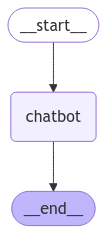

Good Bye


In [22]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
  messages:Annotated[list, add_messages]

graph_builder = StateGraph(State)
graph_builder

def chatbot(state:State):
  return {"messages" : llm.invoke(state['messages'])}

graph_builder.add_node("chatbot",chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile(checkpointer=memory)
from IPython.display import Image, display

try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  pass


while True:
  user_input=input("User: ")
  if user_input.lower() in ["quit","q"]:
    print("Good Bye")
    break
  for event in graph.stream({'messages':("user",user_input)}, config=config):
    print(event.values())
    for value in event.values():
      print(value['messages'])
      print("Assistant:",value["messages"].content)